# U Main

In [1]:
from plotnine import ggplot, aes, geom_line, labs, theme_bw, scale_color_identity
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def method_1(G):
    A = nx.adjacency_matrix(G).todense()
    if np.linalg.matrix_rank(A) < G.number_of_nodes():
        return False
    return True

def method_2(G):
    return nx.algebraic_connectivity(G) > 0

def method_3(G):
    return nx.is_connected(G)



def check_time(seq_k, graph_type, p=None, r=None):

    time_1, time_2, time_3 = [], [], []
    connect_1, connect_2, connect_3 = [], [], []

    for k in seq_k:

        # Define graph type.
        if graph_type == 'ER':
            G = nx.erdos_renyi_graph(k, p)
        elif graph_type == 'rrg':
            G = nx.random_regular_graph(r, k)
        else: 
            print('Invalid value for graph_type!')

        # Method 1: Check irreducibility of the adjacency matrix.
        start_time = time.time()
        check_1 = method_1(G)
        end_time = time.time()
        time_1.append(end_time - start_time)
        connect_1.append(check_1)

        # Method 2: Check second lowest eigenvalue.
        start_time = time.time()
        check_2 = method_2(G)
        end_time = time.time()
        time_2.append(end_time - start_time)
        connect_2.append(check_2)

        # Method 3: Check connectivity using breadth-first search algorithm.
        start_time = time.time()
        check_3 = method_3(G)
        end_time = time.time()
        time_3.append(end_time - start_time)
        connect_3.append(check_3)

    time_data = pd.DataFrame({'k':seq_k, 'Irreducibility': time_1, 'Eigenvalue_of_L': time_2, 'BFS': time_3})

    return time_data, connect_1, connect_2, connect_3

In [4]:
seq_k = np.arange(5,70)
time_data, x,y,z = check_time(seq_k, 'ER', p=.3, r=None)

In [5]:
# Check connectivity with all 3 methods.
for i in range(len(x)):
    if x[i] != y[i] or x[i] != z[i] or y[i] != z[i]:
        print(f'k={i}, x={x[i]}, y={y[i]}, z={z[i]}')

k=4, x=False, y=True, z=True
k=6, x=False, y=True, z=True
k=9, x=False, y=True, z=True
k=11, x=False, y=True, z=True


## 2) - 3) Time plot for different k

In [6]:
import seaborn as sns

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)


col_number = 0
a = sns.color_palette('pastel')[col_number]
rgb_colors = list(map(int, np.array(a) * 255))
print(rgb_to_hex(*rgb_colors))

#a1c9f4


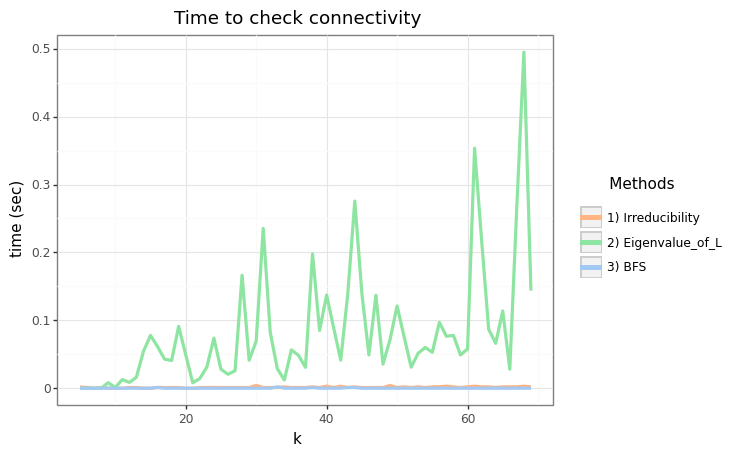

In [8]:
line_size = 1.3

( ggplot(time_data) +
  aes(x='k') +
  geom_line(aes(y='Irreducibility', color = '"#FFB482"'), size = line_size) +
  geom_line(aes(y='Eigenvalue_of_L', color = '"#8DE5A1"'), size = line_size) +
  geom_line(aes(y='BFS', color = '"#A1C9F4"'), size = line_size) +
  labs(x='k', y='time (sec)', title = 'Time to check connectivity') + 
  theme_bw() + 
  scale_color_identity(guide='legend', name = '      Methods \n\n ', breaks=['#FFB482','#8DE5A1','#A1C9F4'], labels=['1) Irreducibility','2) Eigenvalue_of_L','3) BFS'])).draw()


Given that we found that the method 3 is the fastest, we use it to check connectivity for the next point.

## 4) 

In [9]:
def estimate_pc_er(seq_p, k, num_instances):
    pc_list = []
    for p in seq_p:
        num_connected = 0
        for _ in range(num_instances):
            G = nx.erdos_renyi_graph(k, p)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
k = 100
num_instances = 100
seq_p = np.linspace(0, 1, num=100)

# Estimate pc for Erdos-Reyni graphs.
pc_er = estimate_pc_er(seq_p, k, num_instances)

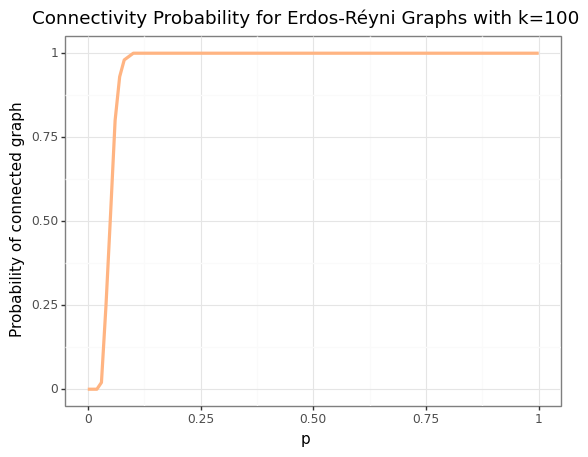

In [10]:
# Plot pc vs p for Erdos-Reyni graphs.
( ggplot(aes(x = seq_p, y = pc_er))+
  labs(x='p',
       y='Probability of connected graph',
       title = 'Connectivity Probability for Erdos-Réyni Graphs with k=100') +
  geom_line(size=line_size, color = '#FFB482') +
  theme_bw()).draw()

In [12]:
def estimate_pc_regular(r, k, num_instances):
    pc_list = []
    for k_val in range(r+1, k+1):
        num_connected = 0
        for _ in range(num_instances):
            G = nx.random_regular_graph(r, k_val)
            if method_3(G):
                num_connected += 1
        pc = num_connected / num_instances
        pc_list.append(pc)
    return pc_list

# Parameters.
r_values = [2, 8]
num_instances = 200
k = 100

# Estimate pc for regular random graphs.
pc_reg = []
for r in r_values:
    pc_r = estimate_pc_regular(r, k, num_instances)
    pc_reg.append(pc_r)

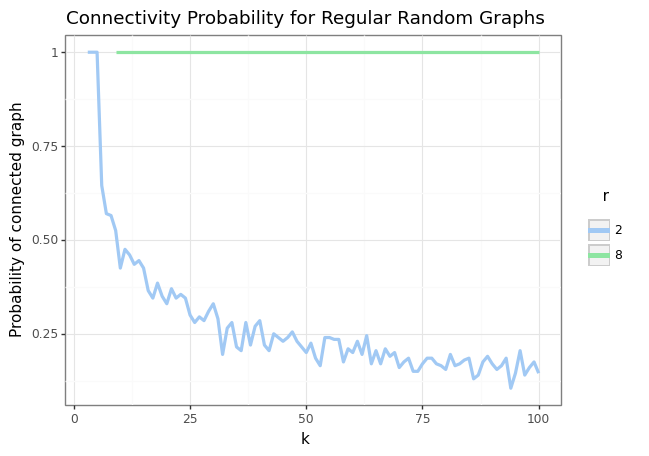

In [13]:
# Plot pc vs k for regular random graphs.
( ggplot() +
  aes(x = np.arange(r_values[0]+1, k+1)) +
  labs(x='k',
        y='Probability of connected graph',
        title = 'Connectivity Probability for Regular Random Graphs') +
  geom_line(aes(y=pc_reg[0], color = '"#A1C9F4"'), size=line_size) +
  geom_line(aes(x = np.arange(r_values[1]+1, k+1),y= pc_reg[1], color='"#8DE5A1"'), size=line_size ) +
  theme_bw() +
  scale_color_identity(guide='legend', name = '   r \n\n ', breaks=['#A1C9F4','#8DE5A1'], labels=['2','8'])).draw()

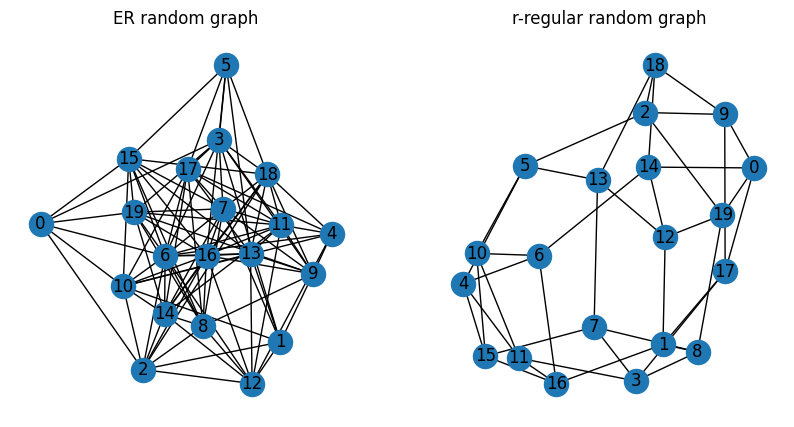

In [8]:
# Plot a cazzo.
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
nx.draw(ER, ax=ax[0], with_labels=True)
nx.draw(rrg, ax=ax[1], with_labels=True)
ax[0].set_title("ER random graph")
ax[1].set_title("r-regular random graph")
plt.show()